Potential outcomes: theory and application

Sources:
- causal inference mixtape 
- Imbens/Rubin 2015 
- Imbens review article JEL
- Dehejia/Wahba 2002 (DW2002). https://business.baylor.edu/scott_cunningham/teaching/dehejia-and-wahba-2002.pdf

I slightly adjusted the comparisons what made most sense for me in the present context but have not compared them all to the original sources.
Specifically, I tried to approximate as closely as possible a real situation where we do not have the experimental controls.

Context
- What is the impact of training the unemployed?
- Unemployed workers are not a random sample of the population. Normally we only have observational data (ie, labor market data, information on job training)
- Lalonde 1986: conducts experiment among unemployed, and compares to existing methods with observational data
- He found that existing methods performed poorly in recovering the true experimental effect from the observational data only
- Dehejia/Wahba repeated Lalonde's analysis, but used (at the time) cutting-edge matching methods

In [751]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
import matplotlib.pyplot as plt 


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from helpers import load_data



### Load data 

In [752]:
nsw_stacked = load_data()

In [753]:
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,randomised,unemp74,unemp75
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012592,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237305,13318.517578,14588.224609,0.027073,0.136217,0.123928
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637695,9372.831055,9702.608398,0.162301,0.343029,0.329509
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236084,3695.896973,5088.759766,0.000000,0.000000,0.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320312,14109.530273,15962.400391,0.000000,0.000000,0.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.339844,22703.080078,25564.669922,0.000000,0.000000,0.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.679688,25243.550781,60307.929688,1.000000,1.000000,1.000000


In [754]:
pd.crosstab(nsw_stacked["treat"], nsw_stacked["randomised"])

randomised,0,1
treat,,
0.0,15992,260
1.0,0,185


### Naive difference in means

- we take the treated from `nsw_dw` and the controls from `nsw_dw_cpscontrol` (ignore the controls from the experiment)

In [733]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["randomised"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["randomised"] == 0)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The non-experimental difference in raw means is {te1:.2f}")

The non-experimental difference in raw means is -8497.52


This number is the same as in Dehejia/Wahba 2022, table 2, row 2, second-last column

### Experimental estimate

We *do* have the experimental data, so let's see the estimate here.

In [734]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["randomised"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["randomised"] == 1)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The experimental difference in raw means is {te1:.2f}")

The experimental difference in raw means is 1794.34


### Sample selection

- discuss the formula/decomposition 
- could we just run a regression and control for the other observed characteristics?
- yes, but the potential outcome approach has the following benefits:
    - it makes us more aware of the required assumptions 
    - in some cases, regression may heavily interpolate between groups; using the methods discussed here puts some more hurdles that prevent us from blindly doing this
- moreover, we can select the covariates $X$ without looking at the outcome $Y$
    - this is also the foundation of the recent methods on "doubly-robust learning"

### Propensity score

- discuss the theorem 
- for discussing balance here, we'd need to match on closest neighbor 

In [735]:
# we'll ignore the experimental controls from now on.
drop = (nsw_stacked["randomised"] == 1) & (nsw_stacked["treat"] == 0)
nsw_stacked = nsw_stacked.loc[~drop, :].copy()

mask_treat = nsw_stacked["treat"] == 1
mask_control = nsw_stacked["treat"] == 0

N_treat = nsw_stacked.loc[mask_treat, :].shape[0]
N_control = nsw_stacked.loc[mask_control, :].shape[0]

assert N_treat + N_control == nsw_stacked.shape[0], "some units got lost"


# nsw_stacked.to_csv("mydf.csv", index=False)

In [736]:
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) +
                    marr + nodegree + black + hisp + earn74 + earn75
                    + unemp74 + unemp75 + I(educ*earn74)""", 
                    family=sm.families.Binomial(),
                   data=nsw_stacked).fit()

nsw_stacked['pscore'] = logit_nsw.predict(nsw_stacked)

In [737]:
vars_to_compare = ["pscore", "age", "nodegree", "earn75"]
print(nsw_stacked.loc[mask_treat, vars_to_compare].describe())
print(nsw_stacked.loc[mask_control, vars_to_compare].describe())


           pscore         age    nodegree        earn75
count  185.000000  185.000000  185.000000    185.000000
mean     0.425357   25.816216    0.708108   1532.055420
std      0.307691    7.155019    0.455867   3219.250732
min      0.001061   17.000000    0.000000      0.000000
25%      0.132217   20.000000    0.000000      0.000000
50%      0.400199   25.000000    1.000000      0.000000
75%      0.670616   29.000000    1.000000   1817.284058
max      0.938455   48.000000    1.000000  25142.240234
             pscore           age      nodegree        earn75
count  1.599200e+04  15992.000000  15992.000000  15992.000000
mean   6.647637e-03     33.225239      0.295835  13650.803711
std    4.166721e-02     11.045216      0.456432   9270.403320
min    1.176785e-09     16.000000      0.000000      0.000000
25%    1.927808e-05     24.000000      0.000000   4398.823242
50%    1.187188e-04     31.000000      0.000000  14557.110352
75%    9.633719e-04     42.000000      1.000000  22923.736816


**Comparing propensity scores between treated and control groups**

The propensity scores are highly imbalanced, and there are a lot of units in the control group whose propensity score is below the minimum in the treatment group.
Since these units will not be contribute information to the estimation (they are not good "counterfactuals" because of their low propensity score), we drop them, like Dehejia/Wahba also did.

**Others notes: Comparing control group to DW2002**
- Same number of observations
- For the control group, the mean propensity score differs from DW2002 (table 2, row 2).
- But the other 3 variables displayed have the same means.
- Thus, somehow the propensity score is misspecified relative to the original paper, but I don't know why.
- (But the propensity scores for treatment and controls are the same as in Cunningham's book)

In [738]:
nsw_stacked.shape

(16177, 15)

In [739]:
display(nsw_stacked.loc[nsw_stacked["treat"] == 0].shape)

(15992, 15)

In [740]:
pscore_threshold = nsw_stacked.loc[mask_treat, "pscore"].min()
mask_pscore_threshold = nsw_stacked["pscore"] >= pscore_threshold

nsw_stacked = nsw_stacked.loc[mask_pscore_threshold, :].copy()

# re-define the masks
mask_treat = (nsw_stacked["treat"] == 1) 
mask_control = (nsw_stacked["treat"] == 0)


display(sum(mask_control))
display(15992 - sum(mask_control)) # this should be 11168 (DW002) or 12611 (DW1999)


3856

12136

In [741]:

def make_hist(df, input_map, xlabel="Value"):
    "Make a histogram of df, mapping over inputs in `input_map`."
    plt.figure(figsize=(6, 4))
    plt.title("Histogram of propensity score")
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.grid(True)

    for label, params in input_map.items():
        x = df.loc[params["mask"], "pscore"]
        # Create histograms for each group
        plt.hist(x, bins=20, density=True, alpha=0.7, color=params["color"], label=label)

        # Add legend
        plt.legend()

    # Display the plot
    plt.show()



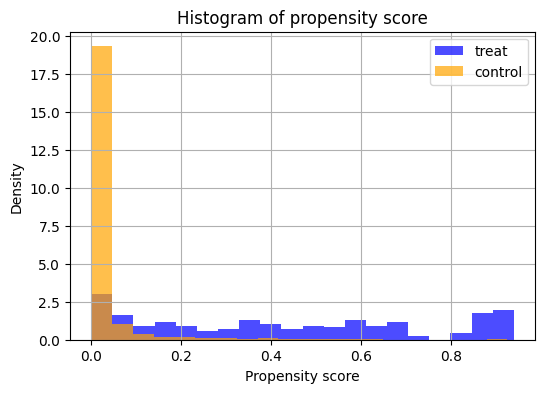

In [742]:
plot_map = {
    "treat": {
        "mask": mask_treat,
        "color": "blue"
    },
    "control": {
        "mask": mask_control,
        "color": "orange"
    }
}

make_hist(nsw_stacked, plot_map, "Propensity score")

A note on assessing balance
- the propensity score is a nice summary of the balance, but makes assumptions about the functional form 
- common support -- see the assumptions for ATE (?)
- alternatively, we can plot differences in means, normalized variances and overlap in the tails to compare the groups

>Unlike CIA, the common support requirement is testable by simply plotting histograms or summarizing the data. Here we do that two ways: by looking at the summary statistics and by looking at a histogram. Let’s start with looking at a distribution in table form before looking at the histogram.



note that independence $\Rightarrow$ balance, so NOT balance $\Rightarrow$ NOT independence. but balance is of course not sufficient for independence.

So we have this huge imbalance. How can we fix it? 


### Propensity score theorem
Assumptions
- conditional independence -- $(Y^1, Y^0) \perp\!\!\!\perp D | X $
- common support, so that we can estimate $E[Y^i | X_i = x]$ for all $x$ and for all $i$

Implication: conditioning on the propensity score is enough to recover the ATE $E[\delta_i (X_i)]$. Common support is necessary in order to estimate the propensity score (why exactly?), and conditional independence is necessary for the propensity score to be sufficient for controlling for all confounding.

Relation to the BLUE theorem in linear regression:
- conditioning on all the relevant indepdendent variables is enough to give you an unbiased estimate of $\beta$
- but, moreover, we have collapsed the matrix of Xs into a single number

**How can we use the propensity score**
- Reweighting 
- Subclassification
- Matching on the propensity score 

Imbens/Rubin prefer subclassification over reweighting because 
- propensity score is estimated with noise, and this enters the denominator in the reweighting schemes, creating bias 
- subclassification has smaller sampling variance because it smoothes over extreme values of the propensity score


We'll match on the log odds ratio instead of the propensity score directly

In [743]:
pscore = nsw_stacked.loc[:, "pscore"].copy()
lps = np.log(pscore / (1 - pscore))
nsw_stacked.loc[:, "lps"] = lps

### Matching on the propensity score

In [744]:

df_treated = nsw_stacked.loc[mask_treat, :]
df_controls = nsw_stacked.loc[mask_control, :]


assert df_treated.index.is_unique
assert df_controls.index.is_unique

df_treated = df_treated.reset_index()
df_controls = df_controls.reset_index()

In [745]:
# we'll use the indexes for tracking the matches
treated = df_treated.loc[:, ["index", "lps"]].to_numpy() # we'll use the index to keep track of the 
controls = df_controls.loc[:, ["index", "lps"]].to_numpy()

# sort from highest to lowest lps
treated = treated[treated[:, 1].argsort()[::-1]] #https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order

display(controls.shape)

(3856, 2)

In [746]:
# matching without replacement
matched = []
k = 1 # number of matched control units
for idx_treat in range(N_treat):
    distance = (treated[idx_treat, 1] - controls[:, 1])**2
    idx_min = np.argsort(distance)[:k]  # index of the min 
    idx_ctrl = controls[idx_min][:, 0] # index of the matched control

    # update the pool of controls: drop the matched unit
    mask = np.full(distance.shape, True)
    mask[idx_min] = False
    controls = controls[mask, ...]
    
    # add the matched control index to matched_controls
    # matched += [(int(x), idx_treat) ]
    matched += [(int(x), idx_treat) for x in idx_ctrl]

In [747]:
matched = pd.DataFrame(np.array(matched), columns=["idx_ctrl", "idx_treat"])
mask_pscore_control = df_controls["index"].isin(matched["idx_ctrl"]) 
display(sum(mask_pscore_control))
display(df_treated.shape)

185

(185, 17)

In [748]:
df_controls.loc[mask_pscore_control, vars_to_compare].describe()

,pscore,age,nodegree,earn75
count,185.000000,185.000000,185.000000,185.000000
mean,0.298792,25.545946,0.616216,1781.612793
std,0.218909,8.018274,0.487626,3396.027588
min,0.001062,16.000000,0.000000,0.000000
25%,0.132049,19.000000,0.000000,0.000000
50%,0.259063,24.000000,1.000000,0.000000
75%,0.411690,30.000000,1.000000,2225.371094
max,0.923979,55.000000,1.000000,20268.240234


In [749]:
y1 = df_treated.loc[:, yvar].mean()
y0 = df_controls.loc[mask_pscore_control, yvar].mean()
te_pscore = y1 - y0
print(f"Estimated treatment effect: {te_pscore:.2f}")


Estimated treatment effect: 1109.70


#### Differences to DW2002

- We get closer to the true causal effect, but are still quite far away
- DW2002 performed much better still.
- Our estimate is much smaller than theirs. 
- control group has different means across the variables displayed above, indicating that they are different set from the control units in DW2002
- other things
    - no indication here: https://cameron.econ.ucdavis.edu/mmabook/mma25p1treatment.txt
    - double-checked the propensity score in R, but the formula should be correct


### Subclassification on the propensity score (unfinished)

The idea is to create blocks of observations in the treatment and control group that have similar propensity scores. Then, take the difference in the outcome within those groups, and average the differences across groups to get an estimate of the ATE. In other words, we assume that there as a block-randomized experiment where treatment assignment was random within each block.

How do we find the blocks? Imbens/Rubin (chapter 17.3) propose the following algorithm
1. Start with a single block, with boundaries equal to 0 and 1
2. Compute 2 statistics to decide whether the block should be further splitted or not:
    - Compute t-statistic testing the H0 that the average value of the propensity score is the same in treatment and control groups. 
    - Compute the number of observations in treatment and control groups that would remain in two new blocks created by splitting the current block at the median of the propensity score 
3. While t-statistic > threshold and new block sizes sufficiently large:
    - Split the block
    - Update the statistics above 


We need to define the following parameters
- t_max = 1.96
- the minimum number of treated or control units in a new block
- the minimum number of units (T + C) in a new block

In [27]:
t_max = 1.96 
N_min1 = 3 
N_min2 = 2

In [28]:
nsw_stacked.head()
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,randomised,unemp74,unemp75,pscore
count,4041.000000,4041.000000,4041.000000,4041.00000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000
mean,0.045781,26.302649,10.976986,0.27419,0.122494,0.395942,0.514477,5473.653809,4194.241699,8144.358398,0.045781,0.374660,0.315516,0.045296
std,0.209035,8.930160,2.245505,0.44616,0.327897,0.489112,0.499852,7058.390625,5671.688477,7938.381348,0.209035,0.484095,0.464779,0.132632
min,0.000000,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001061
25%,0.000000,19.000000,10.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,196.537598,0.000000,0.000000,0.000000,0.002140
50%,0.000000,24.000000,11.000000,0.00000,0.000000,0.000000,1.000000,1775.095947,1620.241943,6408.950195,0.000000,0.000000,0.000000,0.005382
75%,0.000000,31.000000,12.000000,1.00000,0.000000,1.000000,1.000000,9708.166992,6409.354980,13549.269531,0.000000,1.000000,1.000000,0.015611
max,1.000000,55.000000,18.000000,1.00000,1.000000,1.000000,1.000000,35040.070312,25243.550781,60307.929688,1.000000,1.000000,1.000000,0.938455


In [19]:
# we'll use the linearized propensity score instead 
# nsw_stacked["lps"] = np.log(nsw_stacked["pscore"])
data = nsw_stacked.loc[:, ["treat", "lps"]].to_numpy()
b = np.ones((data.shape[0],1))
data = np.c_[data, b]

# compute the t-stat
W = data[:, 0] #treatment indicator

def summarise(a, block, W):
    """In a block for group W, compute:
    - the average propensity score
    - the number of observations
    - the within-group variance
    """
    # TODO: there are assumptions on which columns are which variable
    # perhaps just use vectors directly?

    N = np.sum(block * W)
    l = 1 / N * np.transpose(a[:, 1] * block).dot(W)
    sum_of_squared_diff = np.sum((a[:, 2] * block - l)**2)

    return l, N, sum_of_squared_diff

l_1, N_1, s2_1 = summarise(data, block=data[:, 2], W=W)
l_0, N_0, s2_0 = summarise(data, block=data[:, 2], W=np.ones(W.shape) - W)
s_hat = 1 / (N_1 + N_0 - 2) * (s2_0 + s2_1)

t_stat = (l_1 - l_0) / (np.sqrt(s_hat * (1 / N_1 + 1 / N_0)))

# count number of observation in a block if split by the median propensity score 
mid = np.median(data[:, 1])
block_a = data[:, 1] <= mid 
block_b = data[:, 1] > mid 

np.sum(data[:, 2] * block_a * W )
np.sum(data[:, 2] * block_a * (np.ones(W.shape) - W) )

np.sum(data[:, 2] * block_b * W )
# np.sum(data[:, 2] * block_b * (np.ones(W.shape) - W) )


176.0

In [25]:
# # matching without replacement -- working code
# matched = []
# for idx_treat in range(N_treat):
#     distance = (treated[idx_treat, 1] - controls[:, 1])**2
#     idx_min = np.argmin(distance) # index of the min 
#     idx_ctrl = controls[idx_min][0] # index of the matched control
#     # update the pool of controls: drop the matched unit
#     mask = np.full(distance.shape, True)
#     mask[idx_min] = False
#     controls = controls[mask, ...]
#     # add the matched control index to matched_controls
#     matched.append((int(idx_ctrl), idx_treat))